This scripts trains a single network model for fingerprinting at 19 locations.

Inputs are the same as the ones from delta modelling ANNs, outputs are 6 (boudary sources) $\times$ 19 (locations).
# Preparation:

## Hyper-parameters

In [1]:
import os
import sys
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates
import datetime
import time

google_drive_dir = 'fingerprinting'
input_file = "dsm2_ann_inputs_historical_ec.xlsx"
data_folder = 'Data'
num_input_variables = 9


interval = '1D'

train_models = True
resume_training = False

epochs = 5000
batch_size = 128
initial_lr=0.001

train_ratio = 0.7
which_70pct = 'first' # choose training set split, available choices: 'first', 'last', 'first_n_last'


# Usage of resnet blocks: res10x3x1x1
# filters, kernel_size, stride, stages (# of resnet layers in the block)
# model_str_def = 'res10x3x1x1_f_d8_d2_o1'


'''
6 architectures are available:
MLP; LSTM; GRU; ResNet; Res-LSTM; Res-GRU
'''
## 1. To train an MLP Network: (uncomment both 2 lines below):
model_str_def = 'd8_d2_o1'
input_prepro_option=1

# # 2. To train an LSTM Network (uncomment both 2 lines below):
# model_str_def = 'lstm8_f_o1'
# input_prepro_option = 2

# # 3. To train a GRU Network (uncomment both 2 lines below):
# model_str_def = 'g8_f_o1'
# input_prepro_option = 2

# ## 4. To train a ResNet (uncomment both 2 lines below):
# model_str_def = 'resnet_16_8'
# num_res_blocks=1
# num_neurons_multiplier = [int(x) for x in model_str_def.split('_')[1:]]
# input_prepro_option = 2

# # 5. To train a Res-LSTM or Res-GRU (uncomment both 3 lines below):
# model_str_def = 'residual_gru_8_2' # choose between ['residual_lstm_8_2', 'residual_gru_8_2']
# num_neurons_multiplier=[int(x) for x in model_str_def.split('_')[2:]]
# input_prepro_option = 2

'''
Hyperparameters for Transformer and Res-Transformer
'''
# Size of each attention head for query and key (key_dim in MultiHeadAttention layer)
head_size=256 # was 256
# Number of attention heads (num_heads in MultiHeadAttention layer)
num_heads=4 # was 4
# Dropout probability of MultiHeadAttention layer
dropout=0.25 # was 0.25
# Number of Convolutional filters in the feedforward part (after attention module) of a Transformer Encoder
ff_dim=4
# Number of Transformer Blocks/Encoders
num_transformer_blocks=4 # was 4
# A List of numbers of neurons in the MLP layers (after all Transformer Encoders)
mlp_units=[256] # was [128]
# Dropout probability of MLP layers (after all Transformer Encoders)
mlp_dropout=0.4 # was 0.4

# # 6. To train a Transformer (uncomment both 2 lines below):
# model_str_def = 'transformer'
# input_prepro_option = 2

# # 7. To train a Res-Transformer (uncomment all lines below):
# model_str_def = 'residual_xfm_8_2'
# input_prepro_option = 2
# num_neurons_multiplier=[int(x) for x in model_str_def.split('_')[2:]]


from google.colab import drive
drive.mount('/content/drive',force_remount=True)
gdrive_root_path = os.path.join('/content/drive','My Drive',google_drive_dir)
given_name=None
exclude_input_variable='Martinez_input'


sys.path.append(gdrive_root_path)
import preprocessing_utils

if input_prepro_option ==1:
    # option 1: apply pre-defined average windowing:
    ndays=8
    window_size=11
    nwindows=10
elif input_prepro_option ==2:
    # option 2: directly use daily measurements as inputs
    ndays=118
    window_size=0
    nwindows=0
else:
    raise "input_prepro_option=%d is not supported, please select between {0, 1}" % input_prepro_option

# percentile thresholds for ranged results
percentiles = [0,0.75,0.95]

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
!pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
#import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

for folder_name in ['results','models','images']:
    save_path = os.path.join(gdrive_root_path,folder_name)
    if not os.path.exists(save_path):
        # Create the directory if it does not exist
        os.makedirs(save_path)


## Read data

In [3]:
print('Input data: %s' % (input_file))
input_data_path = os.path.join(gdrive_root_path,data_folder,input_file)
dflist = [pd.read_excel(input_data_path,i,index_col=0,parse_dates=True) for i in range(num_input_variables-1)]
dfinps = pd.concat(dflist,axis=1).dropna(axis=0)
dfinps.drop(columns=exclude_input_variable,inplace=True,errors='ignore')

Input data: dsm2_ann_inputs_historical_ec.xlsx


In [4]:
print('Output data folder: %s' % (data_folder))
output_data_path = os.path.join(gdrive_root_path,data_folder)
boundary_sources = [csv_file.replace('.csv','') for csv_file in os.listdir(output_data_path) if csv_file.endswith(".csv")]
try:
    boundary_sources.remove('All') # delete the csv file of summation of all boundary sources
except:
    pass

print('Found %d boundary sources: %s' % (len(boundary_sources),', '.join(boundary_sources)))

outputs = [pd.read_csv(os.path.join(output_data_path,output_variable+'.csv'),
                       index_col=0,
                       parse_dates=True) for output_variable in boundary_sources]
locations = outputs[0].columns

dfouts = pd.concat(outputs, axis=1)
dfouts.columns = pd.MultiIndex.from_product([boundary_sources, locations],
                                           names=['Boundary Sources', 'Locations'])

Output data folder: Data
Found 6 boundary sources: Ag, SAC, Jones, MTZ, East, SJR


In [5]:
# Align input and output data
df_inpout = pd.merge(dfinps, dfouts, left_index=True, right_index=True)
# Then split the aligned data into inputs and outputs
dfinps = df_inpout[dfinps.columns]
dfouts = df_inpout.loc[:,~df_inpout.columns.isin(dfinps.columns)]

<ipython-input-5-694e84093004>:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_inpout = pd.merge(dfinps, dfouts, left_index=True, right_index=True)


In [6]:
dfinps

,northern_flow,sjr_flow,exports,/HIST+GATE/RSAC128/POS/01JAN1953 - 01JAN2020/IR-YEAR/DWR-DMS-DSM2/,div+seep-drain_dcd+smcd,daily_max-min,sjr_vernalis_ec,sac_greens_ec
1990-01-01,17014.00,1220.000000,10584.1,1.0,1846.29,5.4,1098.00,114.40
1990-01-02,17120.00,1210.000000,10608.8,1.0,1520.36,5.3,1106.00,115.00
1990-01-03,16026.00,1190.000000,10508.2,1.0,1749.70,5.0,1114.00,112.00
1990-01-04,15617.00,1170.000000,10604.3,1.0,1767.28,5.0,1093.00,121.00
1990-01-05,15004.00,1190.000000,10572.1,1.0,1719.83,5.5,1115.00,122.00
...,...,...,...,...,...,...,...,...
2019-12-27,19995.57,2345.708252,10677.0,0.0,1614.06,6.4,605.81,179.46
2019-12-28,19178.19,2338.458252,11272.0,0.0,1377.12,6.1,656.82,182.79
2019-12-29,18651.57,2322.088623,10927.0,0.0,747.41,5.7,631.26,184.52
2019-12-30,18096.47,2310.291748,10325.0,0.0,414.61,5.2,643.28,185.60


In [7]:
dfouts

,"(Ag, BAC)","(Ag, BDT)","(Ag, CLIFTON_COURT)","(Ag, FRK_FRANKSTRACT)","(Ag, GLCGS)","(Ag, GLE)","(Ag, MDM)","(Ag, MHO)","(Ag, MSD)","(Ag, MTB)",...,"(SJR, MTB)","(SJR, OLD)","(SJR, ORCCF)","(SJR, PPT)","(SJR, RINDG)","(SJR, SJG)","(SJR, UNI)","(SJR, VIC)","(SJR, VNI)","(SJR, WDCUT)"
1990-01-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1990-01-02,0.171,0.028,0.057,0.016,0.164,0.282,0.162,10.987,0.181,1.004,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1990-01-03,0.349,0.101,0.324,0.068,0.634,0.976,0.527,23.392,0.979,2.869,...,0.000,0.000,0.000,0.000,0.000,0.000,24.688,0.000,0.000,0.000
1990-01-04,0.410,0.245,0.634,0.148,1.225,1.531,0.808,27.451,1.530,3.672,...,0.000,5.784,0.000,0.000,0.000,0.000,93.481,0.000,0.000,0.000
1990-01-05,0.529,0.508,0.871,0.248,1.628,2.232,0.894,26.743,1.449,3.352,...,0.000,53.594,1.936,0.000,0.000,0.000,91.547,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.974,0.041,6.208,3.283,2.577,0.738,6.806,32.670,0.029,23.087,...,23.497,98.044,36.000,1.456,75.029,99.082,99.644,18.215,0.478,2.032
2019-12-28,3.939,0.038,6.096,3.232,2.402,0.778,6.667,28.323,0.046,20.442,...,21.393,97.615,34.598,1.389,74.246,99.384,99.604,16.970,0.409,1.899
2019-12-29,3.970,0.057,6.014,3.199,2.626,1.078,6.567,30.813,0.065,19.098,...,19.707,97.031,32.983,1.258,73.678,99.416,99.428,16.014,0.327,1.738
2019-12-30,4.011,0.086,6.037,3.184,2.860,1.261,6.508,33.736,0.077,19.689,...,18.438,96.628,34.723,1.114,73.340,99.415,99.358,15.192,0.337,1.566


## Training and Test Periods
Training is from 1989 - 2013 and Validation from 2014 - 2020

The output locations are names of the columns in the output(labels) csv files. For each location, an ANN is trained on all the specified data sets

In [8]:
start_year = max(dfinps.index[0].year, dfouts.index[0].year)
end_year = min(dfinps.index[-1].year, dfouts.index[-1].year)

if which_70pct =='first':
    calib_slice = slice(str(start_year), str(int(start_year+train_ratio*(end_year-start_year))))
    valid_slice = slice(str(int(start_year+train_ratio*(end_year-start_year))+1), str(end_year))
elif which_70pct =='last':
    calib_slice = slice(str(int(start_year+(1-train_ratio)*(end_year-start_year))+1), str(end_year))
    valid_slice = slice(str(start_year), str(int(start_year+(1-train_ratio)*(end_year-start_year))))
elif which_70pct =='first_n_last':
    calib_slice = [slice(str(start_year),
                            str(int(start_year+train_ratio/2*(end_year-start_year)))),
                    slice(str(int(start_year+(1-train_ratio/2)*(end_year-start_year))+1),
                            str(end_year))]
    valid_slice = slice(str(int(start_year+train_ratio/2*(end_year-start_year))+1),
                        str(int(start_year+(1-train_ratio/2)*(end_year-start_year))))
else:
    raise Exception('Unknown data splitting method')
print('Training set:', calib_slice)
print('Test set:', valid_slice)

Training set: slice('1990', '2010', None)
Test set: slice('2011', '2019', None)


## ResNet Block Building Function

In [9]:
parameters = {
    "kernel_initializer": "he_normal"
}

def basic_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
    force_identity_shortcut=False
):
    """
    A one-dimensional basic block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        if block != 0 or stage == 0:
            stride = 1
        else:
            stride = 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2a".format(stage_char, block_char))(x)
        y = keras.layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu", name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block != 0 or force_identity_shortcut:
            shortcut = x
        else:
            shortcut = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])

        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f


def bottleneck_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
):
    """
    A one-dimensional bottleneck block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        stride = 1 if block != 0 or stage == 0 else 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2b_relu".format(stage_char, block_char))(y)

        y = keras.layers.Conv1D(filters * 4, 1, use_bias=False,
                                name="res{}{}_branch2c".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block == 0:
            shortcut = keras.layers.Conv1D(filters * 4, 1, strides=stride, use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        else:
            shortcut = x

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])
        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f

## Transformer and Res-Transformer Building Functions

In [10]:
''' Transformer and Res-Transformer '''
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def transformer(x,
                num_transformer_blocks,
                head_size,
                num_heads,
                ff_dim,
                mlp_units,
                dropout,
                mlp_dropout):
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    return x

def build_transformer(head_size,
                      num_heads,
                      ff_dim,
                      num_transformer_blocks,
                      mlp_units,
                      output_shape,
                      dropout=0,
                      mlp_dropout=0):
    inputs = keras.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    x = transformer(x,
                    num_transformer_blocks=num_transformer_blocks,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_dim=ff_dim,
                    mlp_units=mlp_units,
                    dropout=dropout,
                    mlp_dropout=mlp_dropout)

    outputs = layers.Dense(output_shape)(x)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model


def build_residual_xfmer_model(head_size=256,
                             num_heads=4,
                             ff_dim=4,
                             num_transformer_blocks=4,
                             mlp_units=[128],
                             mlp_dropout=0.4,
                             dropout=0.25,
                             nhidden1=8, nhidden2=2, output_shape=1,
                             act_func='sigmoid',conv_init=None):

    # prepare input layers
    inputs = layers.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    y = layers.Permute((2,1))(x)

    y = tf.keras.layers.Conv1D(8+10,1, activation='relu',
                            kernel_initializer=conv_init,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
                            trainable=False)(y)

    y = layers.Flatten()(y)

    # build main MLP branch
    y = layers.Dense(nhidden1, activation=act_func)(y)
    y = layers.Dense(nhidden2, activation=act_func)(y)
    y = layers.Dense(output_shape, activation=keras.activations.linear,name='mlp_output')(y)

    # build shortcut branch with a transformer
    shortcut = transformer(x,
                           num_transformer_blocks=num_transformer_blocks,
                           head_size=head_size, num_heads=num_heads,
                           ff_dim=ff_dim, mlp_units=mlp_units,
                           dropout=dropout, mlp_dropout=mlp_dropout)
    shortcut = layers.Dense(output_shape, activation=act_func,name='xfmer_shortcut_output')(shortcut)


    outputs = layers.Add(name="res_add")([y, shortcut])
    # outputs = layers.Activation("relu",name="res_relu")(outputs)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

## Main Model building functions

In [11]:
"""# Custom loss function"""
def mse_loss_masked(y_true, y_pred):
    squared_diff = tf.reduce_sum(tf.math.squared_difference(y_pred[y_true>0],y_true[y_true>0]))
    return squared_diff/(tf.reduce_sum(tf.cast(y_true>0, tf.float32))+0.01)

# Define Sequential model
NFEATURES = (num_input_variables-1) # * (ndays + nwindows)
def build_layer_from_string_def(s='i120',width_multiplier=1,
                                block=0,
                                force_identity_shortcut=False,
                                return_sequences_rnn=True):
    if s[0:4] == 'lstm':
        return layers.LSTM(units = int(s[4:])*width_multiplier, return_sequences=return_sequences_rnn, activation='sigmoid')
    elif s[0:3] == 'res':
        fields = s[3:].split('x')
        return basic_1d(filters=int(fields[0]),
                        stage=int(fields[3]),
                        block=block,
                        kernel_size=int(fields[1]),
                        stride=int(fields[2]),
                        force_identity_shortcut=force_identity_shortcut)
    elif s[0:3] == 'c1d':
        fields = s[3:].split('x')
        return keras.layers.Conv1D(filters=int(fields[0]), kernel_size=int(fields[1]), strides=int(fields[2]),
                                   padding='causal', activation='linear')
    elif s[0:2] == 'td':
        return keras.layers.TimeDistributed(keras.layers.Dense(int(s[2:]), activation='elu'))
    elif s[0:2] == 'dr':
        return keras.layers.Dropout(float(s[2:]))
    # elif s[0] == 'i':
    #     return keras.layers.InputLayer(input_shape=[int(s[1:]), NFEATURES])
    elif s[0] == 'f':
        return keras.layers.Flatten()
    elif s[0] == 'g':
        return keras.layers.GRU(int(s[1:])*width_multiplier, return_sequences=return_sequences_rnn, activation='relu')
    elif s[0] == 'd':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='elu')
    elif s[0] == 'o':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='linear')
    else:
        raise Exception('Unknown layer def: %s' % s)

In [12]:
def build_model_from_string_def(strdef='i120_f_d4_d2_d1',width_multiplier=1):
    layer_strings = strdef.split('_')
    inputs = keras.layers.Input(shape=[int(layer_strings[0][1:]) * NFEATURES])
    x = None
    prev_conv_output_num_of_channels = None
    return_sequences_rnn = None
    for block,f in enumerate(layer_strings[1:-1]):
        if x is None:
            if f.startswith(('lstm','g')):
                # these layers require 2D inputs and permutation
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
                x = layers.Permute((2,1))(x)
                # return_sequences_rnn = layer_strings[block+2].startswith(('lstm','g','res','c1d'))
                return_sequences_rnn = True
            elif f.startswith(('res','c1d')):
                # these layers require 2D inputs
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
            else:
                x = inputs


        x = build_layer_from_string_def(f,width_multiplier,block,
                                        force_identity_shortcut=(f.startswith('res') and prev_conv_output_num_of_channels==int(f[3:].split('x')[0])),
                                        return_sequences_rnn=return_sequences_rnn)(x)
        if f.startswith('lstm'):
            prev_conv_output_num_of_channels=int(f[4:])
        elif f.startswith('res') or f.startswith('c1d'):
            prev_conv_output_num_of_channels=int(f[3:].split('x')[0])


    outputs = keras.layers.Dense(int(layer_strings[-1][1:])*width_multiplier, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_resnet_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',
                       filters=num_input_variables-1, kernel_size=3, stride=1,
                       num_res_blocks=1):
    inputs = layers.Input(shape=NFEATURES* (ndays + nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    for ii in range(num_res_blocks - 1):
        # TODO: think about conv filter numbers and kernel sizes
        intermediate_features = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" %ii)(x)
        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2a" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2a_relu" % ii)(intermediate_features)

        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2b" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2b_relu" % ii)(intermediate_features)

        shortcut = x
        x = layers.Add(name="res%d_add" % ii)([intermediate_features, shortcut])

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" % num_res_blocks)(x)
    y = layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res%d_branch2a" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu", name="res%d_branch2a_relu" % num_res_blocks)(y)

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2b" % num_res_blocks)(y)
    y = layers.Conv1D(filters,kernel_size,use_bias=False,
                            name="res%d_branch2b" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)

    shortcut = inputs
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)

    y = layers.Add(name="res%d_add" % num_res_blocks)([y, shortcut])

    y = layers.Activation("relu",name="res_relu")(y)


    y = layers.Dense(nhidden2, activation=act_func)(y)
    outputs= layers.Dense(output_shape, activation=keras.activations.linear,name='output')(y)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_residual_lstm_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',layer_type='lstm',conv_init=None):
    rnn_layer = layers.LSTM if layer_type == 'lstm' else layers.GRU
    inputs = layers.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,num_input_variables-1))(inputs)
    x = layers.Permute((2,1))(x)

    y = tf.keras.layers.Conv1D(8+10,1, activation='relu',
                            kernel_initializer=conv_init,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
                            trainable=False)(x)

    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)
    y = layers.Dense(nhidden2, activation=act_func)(y)
    y = layers.Dense(output_shape, activation=keras.activations.linear,name='mlp_output')(y)


    shortcut = layers.Dense(nhidden1, activation=act_func)(x)
    shortcut = rnn_layer(units = output_shape*2, activation=act_func,return_sequences=True)(shortcut)
    shortcut = layers.Flatten()(shortcut)
    shortcut = layers.Dense(output_shape, activation=keras.activations.linear,name='lstm_output')(shortcut)

    outputs = layers.Add(name="res_add")([y, shortcut])
    # outputs = layers.Activation("relu",name="res_relu")(outputs)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(head_size,
                      num_heads,
                      ff_dim,
                      num_transformer_blocks,
                      mlp_units,
                      output_shape,
                      dropout=0,
                      mlp_dropout=0):
    inputs = keras.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(output_shape)(x)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

# Train Models

In [13]:
full_model_str_def = 'i%d_'%(ndays + nwindows) +model_str_def
if train_models:

    model_path_prefix = "mtl_fingerprinting_%s_%s" % (full_model_str_def,which_70pct+'_chronological')


    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
    preprocessing_utils.create_training_sets([dfinps],
                                [dfouts],
                                calib_slice=calib_slice,
                                valid_slice=valid_slice,
                                ndays=ndays,window_size=window_size,nwindows=nwindows)

    if model_str_def.startswith('resnet'):
        model = build_resnet_model(nhidden1=num_neurons_multiplier[0]*yallc.shape[1], nhidden2=num_neurons_multiplier[1]*yallc.shape[1], output_shape=yallc.shape[1],
                                    num_res_blocks=num_res_blocks)
    elif model_str_def.startswith('residual_lstm') or model_str_def.startswith('residual_gru'):
        conv_init = tf.constant_initializer(preprocessing_utils.conv_filter_generator(ndays=8,window_size=11,nwindows=10))

        model = build_residual_lstm_model(num_neurons_multiplier[0]*len(output_stations),
                                num_neurons_multiplier[1]*len(output_stations),
                                output_shape=yallc.shape[1],
                                act_func='sigmoid',
                                layer_type=model_str_def.lower().split('_')[1],
                                conv_init=conv_init)
    elif model_str_def == 'transformer':
        model = build_transformer(head_size=256,
                                num_heads=4,
                                ff_dim=4,
                                num_transformer_blocks=4,
                                mlp_units=[128],
                                output_shape=yallc.shape[1],
                                mlp_dropout=0.4,
                                dropout=0.25)
    elif 'residual_xfm' in model_str_def:
            conv_init = tf.constant_initializer(preprocessing_utils.conv_filter_generator(ndays=8,window_size=11,nwindows=10))

            model = build_residual_xfmer_model(num_transformer_blocks=num_transformer_blocks,
                                            head_size=head_size,
                                            num_heads=num_heads,
                                            ff_dim=ff_dim,
                                            mlp_units=mlp_units,
                                            dropout=dropout,
                                            mlp_dropout=mlp_dropout,
                                            nhidden1=num_neurons_multiplier[0]*yallc.shape[1],
                                            nhidden2=num_neurons_multiplier[1]*yallc.shape[1],
                                            output_shape=yallc.shape[1],
                                            conv_init=conv_init)
    else:
        model = build_model_from_string_def(full_model_str_def,width_multiplier=yallc.shape[1])


    display(model.summary())
    start_time = time.time()
    history = model.fit(
        xallc,
        yallc,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(xallv, yallv),
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=100, mode="min", restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=50, min_lr=1e-6, verbose=1),
        ],
        verbose=2
    )
    print('Finished training %d epochs in %.2f seconds' % (history.epoch[-1], time.time() - start_time))
    preprocessing_utils.save_model(os.path.join(gdrive_root_path, 'models', (given_name or model_path_prefix)) , model, xscaler, yscaler)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144)]             0         
                                                                 
 dense (Dense)               (None, 912)               132240    
                                                                 
 dense_1 (Dense)             (None, 228)               208164    
                                                                 
 dense_2 (Dense)             (None, 114)               26106     
                                                                 
Total params: 366,510
Trainable params: 366,510
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5000
60/60 - 6s - loss: 0.0323 - val_loss: 0.0297 - lr: 0.0010 - 6s/epoch - 96ms/step
Epoch 2/5000
60/60 - 1s - loss: 0.0145 - val_loss: 0.0335 - lr: 0.0010 - 823ms/epoch - 14ms/step
Epoch 3/5000
60/60 - 1s - loss: 0.0130 - val_loss: 0.0451 - lr: 0.0010 - 789ms/epoch - 13ms/step
Epoch 4/5000
60/60 - 1s - loss: 0.0135 - val_loss: 0.0293 - lr: 0.0010 - 933ms/epoch - 16ms/step
Epoch 5/5000
60/60 - 1s - loss: 0.0114 - val_loss: 0.0311 - lr: 0.0010 - 872ms/epoch - 15ms/step
Epoch 6/5000
60/60 - 1s - loss: 0.0111 - val_loss: 0.0303 - lr: 0.0010 - 715ms/epoch - 12ms/step
Epoch 7/5000
60/60 - 1s - loss: 0.0107 - val_loss: 0.0250 - lr: 0.0010 - 964ms/epoch - 16ms/step
Epoch 8/5000
60/60 - 1s - loss: 0.0110 - val_loss: 0.0253 - lr: 0.0010 - 571ms/epoch - 10ms/step
Epoch 9/5000
60/60 - 1s - loss: 0.0099 - val_loss: 0.0273 - lr: 0.0010 - 589ms/epoch - 10ms/step
Epoch 10/5000
60/60 - 1s - loss: 0.0107 - val_loss: 0.0234 - lr: 0.0010 - 622ms/epoch - 10ms/step
Epoch 11/5000
60/60 - 1s - loss:

# Evaluate Models

## Define evaluation metrics

In [14]:
from collections import defaultdict
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE']

def evaluate_sequences(target, pred, metrics):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    valid_entries = target>0
    sequence_length = np.sum(valid_entries)
    # print('Total samples: %d, valid samples: %d' % (len(target), np.sum(valid_entries)))
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))
    eval_results = defaultdict(float)

    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            if SD_pred ==0:
                print('Warning: standard deviation of model prediction is 0, please double check settings.')
                eval_results[m] = np.nan
            else:
                eval_results[m] = np.sum((pred-np.mean(pred)) * (target - np.mean(target))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
    return eval_results

## Compute numerical results

In [15]:
if interval =='1D':
    full_results={}
    range_results=defaultdict(defaultdict)


    df_inpout = pd.concat(dflist[0:(num_input_variables)],axis=1).dropna(axis=0)

    model_path_prefix = "mtl_fingerprinting_%s_%s" % (full_model_str_def,which_70pct+'_chronological')

    # # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
        preprocessing_utils.create_training_sets([dfinps],
                                    [dfouts],
                                    calib_slice=calib_slice,
                                    valid_slice=valid_slice,
                                    ndays=ndays,window_size=window_size,nwindows=nwindows)

    annmodel = preprocessing_utils.load_model(os.path.join(gdrive_root_path,'models', (given_name or model_path_prefix)),custom_objects={"mse_loss_masked": mse_loss_masked})
    train_pred = annmodel.model.predict(xallc)
    test_pred = annmodel.model.predict(xallv)
    all_target = np.concatenate((yallc,yallv),axis=0)
    all_pred = np.concatenate((train_pred,test_pred),axis=0)

    for ii, (source, location) in enumerate(yallc.columns):
        loc_source = location+'_'+source
        train_results = evaluate_sequences(train_pred[:,ii], yallc.iloc[:,ii], eval_metrics)
        train_results['R^2'] = r2_score(train_pred[:,ii], yallc.iloc[:,ii])
        full_results['%s_train' %loc_source] = train_results

        eval_results = evaluate_sequences(test_pred[:,ii], yallv.iloc[:,ii], eval_metrics)
        eval_results['R^2'] = r2_score(test_pred[:,ii], yallv.iloc[:,ii])
        full_results['%s_test' %loc_source] = eval_results

        for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
            lower_threshold = np.quantile(all_target[:,ii], lower_quantile)
            upper_threshold = np.quantile(all_target[:,ii], upper_quantile)
            eval_results = evaluate_sequences(all_target[(all_target[:,ii] > lower_threshold) & (all_target[:,ii] <= upper_threshold),ii],
                                                all_pred[(all_target[:,ii] > lower_threshold) & (all_target[:,ii] <= upper_threshold),ii],
                                                eval_metrics)
            range_results[location][lower_quantile*100] = eval_results

103/103 [==============================] - 0s 2ms/step


In [16]:
full_results

{'BAC_Ag_train': defaultdict(float,
             {'MSE': 0.002359821147670311,
              'Bias': -10.414863652379143,
              'R': 0.8919478817389379,
              'RMSD': 0.014631562915921966,
              'NSE': 0.7113943298199596,
              'R^2': 0.7116032831881232}),
 'BAC_Ag_test': defaultdict(float,
             {'MSE': 0.004446731418670228,
              'Bias': -4.525883980696361,
              'R': 0.8104449295086761,
              'RMSD': 0.014875991160027585,
              'NSE': 0.5981264648100684,
              'R^2': 0.6134836953350373}),
 'BDT_Ag_train': defaultdict(float,
             {'MSE': 0.0037040194757063877,
              'Bias': -26.87423143873194,
              'R': 0.9075121423361975,
              'RMSD': 0.047276711072950686,
              'NSE': 0.7531242108654927,
              'R^2': 0.7616328434173213}),
 'BDT_Ag_test': defaultdict(float,
             {'MSE': 0.01918710810479194,
              'Bias': 31.91779281414147,
              'R'

## Save numerical results to Google Drive

In [17]:
import pickle

# create a pickle file on Google Drive and write results
result_path_prefix = "mtl_fingerprinting_%s_%s" % (full_model_str_def,which_70pct+'_chronological')

result_root_path = os.path.join(gdrive_root_path,"results")

results_path = os.path.join(result_root_path, "%s_results.pkl" % (result_path_prefix))

f = open(results_path,"wb")
pickle.dump(full_results,f)
f.close()
print('Numerical results saved to %s' % results_path)

# range_results_path = os.path.join(gdrive_root_path,"results/%s_ranged_results.pkl" % (result_path_prefix))

# f = open(range_results_path,"wb")
# pickle.dump(range_results,f)
# f.close()
# print('Ranged numerical results saved to %s' % range_results_path)

Numerical results saved to /content/drive/My Drive/fingerprinting/results/mtl_fingerprinting_i18_d8_d2_o1_first_chronological_results.pkl


In [18]:
print(full_results)

{'BAC_Ag_train': defaultdict(<class 'float'>, {'MSE': 0.002359821147670311, 'Bias': -10.414863652379143, 'R': 0.8919478817389379, 'RMSD': 0.014631562915921966, 'NSE': 0.7113943298199596, 'R^2': 0.7116032831881232}), 'BAC_Ag_test': defaultdict(<class 'float'>, {'MSE': 0.004446731418670228, 'Bias': -4.525883980696361, 'R': 0.8104449295086761, 'RMSD': 0.014875991160027585, 'NSE': 0.5981264648100684, 'R^2': 0.6134836953350373}), 'BDT_Ag_train': defaultdict(<class 'float'>, {'MSE': 0.0037040194757063877, 'Bias': -26.87423143873194, 'R': 0.9075121423361975, 'RMSD': 0.047276711072950686, 'NSE': 0.7531242108654927, 'R^2': 0.7616328434173213}), 'BDT_Ag_test': defaultdict(<class 'float'>, {'MSE': 0.01918710810479194, 'Bias': 31.91779281414147, 'R': 0.8665804254563235, 'RMSD': 0.056174577697732854, 'NSE': -0.778196634320544, 'R^2': -0.5212829195958366}), 'CLIFTON_COURT_Ag_train': defaultdict(<class 'float'>, {'MSE': 0.006049631818463914, 'Bias': 6.908149558210898, 'R': 0.9015717083301017, 'RMSD':

## Generate Plots

### Exceedance probability plots and time series plots for key stations

In [19]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144)]             0         
                                                                 
 dense (Dense)               (None, 912)               132240    
                                                                 
 dense_1 (Dense)             (None, 228)               208164    
                                                                 
 dense_2 (Dense)             (None, 114)               26106     
                                                                 
Total params: 366,510
Trainable params: 366,510
Non-trainable params: 0
_________________________________________________________________
Randomly selecting 10840 samples for training, 0 for test
339/339 [==============================] - 1s 2ms/step
Generating combined exceedance plots for key locations BAC


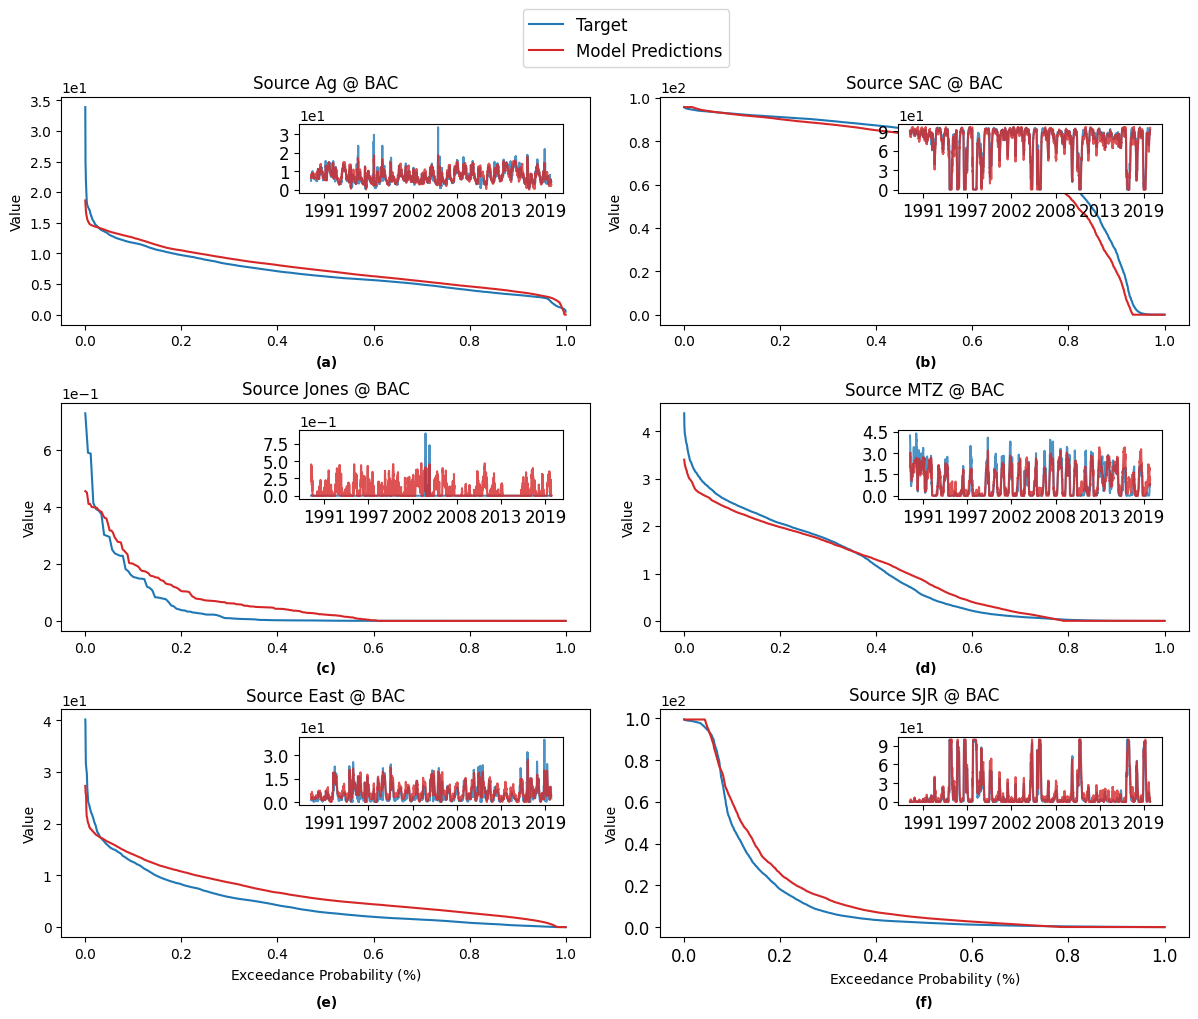

In [20]:

key_locations = locations[:1] # Siyu's note: I simply pick the first location as key station


ncols=2
fig_combined_exceedance, ax_combined_exceedance = plt.subplots(nrows=len(key_locations)*len(boundary_sources)//ncols,
                                                               ncols=ncols,
                                                               figsize=(6*ncols,3*len(key_locations)*len(boundary_sources)//ncols))
fig_combined_exceedance.tight_layout(h_pad=3.5, w_pad=2)
ii = 0

model_path_prefix = "mtl_fingerprinting_%s_%s" % (full_model_str_def,which_70pct+'_chronological')

annmodel = preprocessing_utils.load_model(os.path.join(gdrive_root_path,'models', (given_name or model_path_prefix)),custom_objects={"mse_loss_masked": mse_loss_masked})
model = annmodel.model

model.summary()


(xallc, yallc), (_, _), _,_ = \
preprocessing_utils.create_training_sets([dfinps],
                            [dfouts],
                            train_frac=1.0,
                            ndays=ndays,window_size=window_size,nwindows=nwindows,
                            xscaler=xscaler, yscaler=yscaler)

dfp = yscaler.inverse_transform(pd.DataFrame(np.clip(model.predict(xallc),0,1),yallc.index,columns=yallc.columns))

print('Generating combined exceedance plots for key locations %s' % (', '.join(key_locations)))
ii = 0
for location in key_locations:
    for boundary_source in boundary_sources:
        column_name = (boundary_source, location)
        y = dfouts[boundary_source,location].copy()
        y[y<0] = float('nan')


        # Combined exceedance probability plots
        valid_rows = dfouts[boundary_source,location] > 0
        test_y_sorted = np.sort(y[valid_rows].iloc[(ndays+nwindows*window_size-1):].dropna().to_numpy().reshape(-1,1),axis=0)
        test_pred_sorted = np.sort(dfp[valid_rows.loc[dfp.index[0]:dfp.index[-1]]][boundary_source,location].clip(0,dfouts[boundary_source,location].max()).to_numpy().reshape(-1,1),axis=0)

        # calculate the proportional values of samples
        p = 1. * np.arange(len(test_y_sorted)-1,-1,-1) / (len(test_y_sorted) - 1)
        p_pred = 1. * np.arange(len(test_pred_sorted)-1,-1,-1) / (len(test_pred_sorted) - 1)

        # plot the sorted data:
        ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(p, test_y_sorted,'-',color='C0')
        ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(p_pred, test_pred_sorted,'-',color='C3')
        if ii == ncols:
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].legend(['Target','Model Predictions'],fontsize=12,bbox_to_anchor=(1.28, 2.76))

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
        ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].set_ylabel('Value')
        ylims = ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].get_ylim()
        if ii >= len(key_locations)*len(boundary_sources) - ncols:
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xlabel('Exceedance Probability ' + r"$(\%)$")
            text_yloc = ylims[0]-(ylims[1]-ylims[0])*0.3
        else:
            text_yloc = ylims[0]-(ylims[1]-ylims[0])*0.18

        ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].text(0.48,
                                                                            text_yloc,
                                                                            '(%s)'%chr(97+ii),weight='bold')
        ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].set_title('Source %s @ %s'% (boundary_source,location))

        subax1 = add_subplot_axes(ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)],[0.45,0.58,0.5,0.3]) # xloc, yloc, xwidth, ywidth

        subax1.plot(y.iloc[(ndays+nwindows*window_size-1):],'-',color='C0',alpha=0.8)
        subax1.plot(dfp[boundary_source,location].clip(0,dfouts[boundary_source,location].max(),axis=0),'-',color='C3',alpha=0.8)

        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        subax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
        subax1.yaxis.set_major_locator(ticker.MaxNLocator(4))
        subax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
        subax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ii += 1
fig_combined_exceedance.savefig(os.path.join(gdrive_root_path,"images/%s_combined_exceedance_prob.png"% (given_name or model_path_prefix)),bbox_inches='tight',dpi=300)